# TESS region check script

Developed by: Joseph R. Eggen, NASA-GSFC, Sept. 2018

The purpose of this script is to calculate the total exposure for each
source in a list of blazars. For a given Fermi FT2 file, it will be 
determined which TESS fields are being used, and the exposures of all 
blazars in the provided .csv file that fall within the three TESS regions 
will be calculated.

In [1]:
# Load modules
import os
import re
import sys
import csv
import pandas as pd
import numpy as np
import datetime as dt
import gt_apps as my_apps
from astropy.io import fits
from astropy.table import table
from astropy.time import Time
from astropy import wcs
from astropy import units as u
from photutils import CircularAperture
from photutils import SkyCircularAperture
from astropy.coordinates import SkyCoord
from photutils import aperture_photometry as aphot
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
%matplotlib inline

In [2]:
# Load the FT2 file
#if len(sys.argv) == 2:
#  infile = sys.argv[1]
#if len(sys.argv) == 1:
#  infile = 'SC.fits'
#  print "Using default FT2 file:",infile
#if len(sys.argv) > 2:
#  print "Script accepts either 1 or 0 arguments! Exiting..."
#  exit()

# Start date of science operations is July 25, 2018. TESS will observe 
# 13 sectors per hemispher per year, with a cadence of 27.4 days.
epochStart = 2458324.5 # JD of TESS start date
FermiStart = 554169605 # MET of epochStart
TTime = 27.4 # Time between field switches with TESS, in days

# **** THIS SHOULD BE THE ONLY PARAMETER THAT YOU NEED TO CHANGE :) ****
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_533_2018228_2018235_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_530_2018207_2018214_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_531_2018214_2018221_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_532_2018221_2018228_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_533_2018228_2018235_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_534_2018235_2018242_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_535_2018242_2018249_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_536_2018249_2018256_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_537_2018256_2018263_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_538_2018263_2018270_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_539_2018270_2018277_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_540_2018277_2018284_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_541_2018284_2018291_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_542_2018291_2018298_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_543_2018298_2018305_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_544_2018305_2018312_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_545_2018312_2018319_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_546_2018319_2018326_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_548_2018333_2018340_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_FINAL_549_2018340_2018347_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_PRELIM_550_2018347_2018354_00.fits'
#infile = 'weeklyFT2/FERMI_POINTING_PRELIM_551_2018354_2018361_00.fits'
infile = 'weeklyFT2/FERMI_POINTING_PRELIM_552_2018361_2019003_00.fits'
#infile = 'L1810181103240183532E49_SC00.fits'

fitsFile = fits.open(infile)
data = fitsFile['SC_DATA'].data

MWArray = re.split('_|\.|\/',infile)
if MWArray[1] == "FERMI":
    MWString = MWArray[4]+'_'
else:
    MWString = MWArray[1]+'_'

# Populate arrays
START = data['START']
STOP = data['STOP']

# Load the .csv file
tablefile = 'wtv-blazars-names.csv'
blazar_file = pd.read_csv('wtv-blazars-names.csv',index_col='Name')
#print blazar_file

# Open output file for writing
#outfile = 'TESS_exposures.txt'

In [3]:
# Create timeframes for TESS observing sectors
i = 0
sectors = []
while i < 13:
    S = i + 1
    estart = epochStart + i*TTime
    estop = estart + TTime
    fstart = FermiStart + i*TTime*86400
    fstop = fstart + TTime*86400
    sectors.append([S,estart,estop,fstart,fstop])
    i += 1

# Determine the first and last sectors that the FT2 file 
# spans. Make a list of sectors that spans the entire range
# Use FT2 file to determine which TESS fields are active
# Scan the TSTART values of the FT2. The FT2 file may span 
# 1 or 2 sectors, but no more.
FirstSector = 0
sectorFirstStart = START[0]
for s in range(len(sectors)):
    if sectors[s][3] <= sectorFirstStart <= sectors[s][4]:
        #print sectors[s][3], sectorFirstStart, sectors[s][4]
        FirstSector = s+1
        #print FirstSector

# Last
LastSector = 0
sectorLastStop = STOP[-1]
for s in range(len(sectors)):
    if sectors[s][3] <= sectorLastStop <= sectors[s][4]:
        #print sectors[s][3], sectorLastStop, sectors[s][4]
        LastSector = s+1
        #print LastSector
if LastSector == 0:
    LastSector = FirstSector

# Whole span
print "FirstSector,LastSector",FirstSector,LastSector
if FirstSector != LastSector:
    mySectors = range(FirstSector,LastSector+1)
elif FirstSector == 0:
    mySectors = [LastSector]
else:
    mySectors = [FirstSector]
print "mySectors",mySectors
        
# Define time intervals
intervals = []
if len(mySectors) == 1:
    intervals.append([mySectors[0],START[0],STOP[-1]])
else:
    for mysec in mySectors:
        start = sectors[mysec - 1][3]
        if start < START[0]:
            start = START[0]
        stop = sectors[mysec - 1][4]
        if stop > STOP[-1]:
            stop = STOP[-1]
        interval = [mysec,start,stop]
        intervals.append(interval)

print 'intervals[] =',intervals
print "First TESS segment this mission week covers:",str(intervals[0][0])
print "Time spent in this segment:",intervals[0][1],"to",intervals[0][2]
if len(intervals) > 1:
    print "Second TESS segment this mission week covers:",intervals[1][0]
    print "Time spent in this segment:",intervals[1][1],"to",intervals[1][2]
else:
    print "FT2 file covers only one TESS segment"

FirstSector,LastSector 6 6
mySectors [6]
intervals[] = [[6, 567561540.0, 568166400.0]]
First TESS segment this mission week covers: 6
Time spent in this segment: 567561540.0 to 568166400.0
FT2 file covers only one TESS segment


In [4]:
# Identify which targets are in the TESS FoV during this period. 
# Make a dict of them, along with their coordinates.

# Make sub-tables for blazars observed in different sectors
visibleSources = []
for i in range(len(intervals)):
    secID = 'S'+str(intervals[i][0])
    #print secID
    for j in range(len(blazar_file.index)):
        fovName = secID+'FOV'
        if blazar_file[secID][j] != 0:
            visSrc = [secID,blazar_file.index[j], blazar_file.RA[j], blazar_file.DEC[j],blazar_file[secID][j]]
            visibleSources.append(visSrc)
        #j += 1
    #i += 1

In [5]:
# Use gtexpmap to calculate the exposure for each selected blazar. 
# Give total seconds and fraction of exp./avg. Print results 
# to terminal and output file.

In [6]:
# Make a counts cube (needed for exposure map) for each
# interval, and then make the exposure maps.
for interval in intervals:
    cubeName = 'ltCube/ltCube'+MWString+'S'+str(interval[0])+'.fits'
    mapName = 'expCube/expCube'+MWString+'S'+str(interval[0])+'.fits'
    print 'Time range:',interval[1],'to',interval[2],'=',str(round((interval[2]-interval[1])/86400,2)),'days'
    my_apps.expCube['evfile'] = ''
    my_apps.expCube['evtable'] = 'EVENTS'
    my_apps.expCube['scfile'] = infile
    my_apps.expCube['outfile'] = cubeName
    my_apps.expCube['zmax'] = 105
    my_apps.expCube['dcostheta'] = 0.025
    my_apps.expCube['binsz'] = 1
    my_apps.expCube['tmin'] = interval[1]
    my_apps.expCube['tmax'] = interval[2]
    if not os.path.isfile(cubeName):
        my_apps.expCube.run()
    else:
        print "Exposure Cube file "+cubeName+" exists. Continuing..."

    # Create an all-sky exposure map from the FT2 file and counts cube
    #my_apps.gtexpcube2['evfile'] = ''
    my_apps.gtexpcube2['cmap'] = 'none'
    #my_apps.gtexpcube2['scfile'] = 'FERMI_POINTING_FINAL_533_2018228_2018235_00.fits'
    my_apps.gtexpcube2['infile'] = cubeName
    my_apps.gtexpcube2['outfile'] = mapName
    my_apps.gtexpcube2['evtype'] = 'INDEF'
    my_apps.gtexpcube2['irfs'] = 'P8R2_SOURCE_V6'
    my_apps.gtexpcube2['nxpix'] = 1800
    my_apps.gtexpcube2['nypix'] = 900
    my_apps.gtexpcube2['binsz'] = 1
    my_apps.gtexpcube2['coordsys'] = 'CEL'
    my_apps.gtexpcube2['xref'] = 0
    my_apps.gtexpcube2['yref'] = 0 
    my_apps.gtexpcube2['axisrot'] = 0
    #my_apps.gtexpcube2['proj'] = 'AIT'
    my_apps.gtexpcube2['proj'] = 'CAR'
    my_apps.gtexpcube2['ebinalg'] = 'LOG'
    my_apps.gtexpcube2['emin'] = 100
    my_apps.gtexpcube2['emax'] = 200000
    my_apps.gtexpcube2['enumbins'] = 1
    my_apps.gtexpcube2['ebinfile'] = 'NONE'
    if not os.path.isfile(mapName):
        my_apps.gtexpcube2.run()
    else:
        print "Exposure Map file "+mapName+" exists. Continuing..."

# Now combine the two layers of the all-sky exposure cube into a single image.

Time range: 567561540.0 to 568166400.0 = 7.0 days
time -p gtltcube evfile="" evtable="EVENTS" scfile=weeklyFT2/FERMI_POINTING_PRELIM_552_2018361_2019003_00.fits sctable="SC_DATA" outfile=ltCube/ltCube552_S6.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=567561540.0 tmax=568166400.0 file_version="1" zmin=0.0 zmax=105.0 chatter=2 clobber=yes debug=no gui=no mode="ql"


Working on file weeklyFT2/FERMI_POINTING_PRELIM_552_2018361_2019003_00.fits
.....................!
real 15.59
user 15.16
sys 0.30
time -p gtexpcube2 infile=ltCube/ltCube552_S6.fits cmap=none outfile=expCube/expCube552_S6.fits irfs="P8R2_SOURCE_V6" evtype="INDEF" nxpix=1800 nypix=900 binsz=1.0 coordsys="CEL" xref=0.0 yref=0.0 axisrot=0.0 proj="CAR" ebinalg="LOG" emin=100.0 emax=200000.0 enumbins=1 ebinfile="NONE" hpx_ordering_scheme="RING" hpx_order=6 bincalc="EDGE" ignorephi=no thmax=180.0 thmin=0.0 table="EXPOSURE" chatter=2 clobber=yes debug=no mode="ql"


Computing binned exposure map....................!
real 4.05
user 

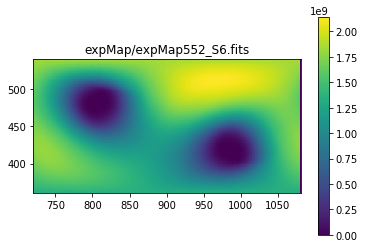

In [7]:
##### stackedExpMap = np.zeros(shape=cubeData[0].shape)
#stackedExpMap = cubeData[0] + cubeData[1]
for interval in intervals:
    expCubeFile = 'expCube/expCube'+MWString+'S'+str(interval[0])+'.fits'
    #expCubeFile = 'expCube'+MWString+'.fits'
    cubeFile = fits.open(expCubeFile)
    cubeData = cubeFile['Primary'].data
    stackedExpMap = np.sum([cubeData[0],cubeData[1]], axis=0)
    expMapFile = 'expMap/expMap'+MWString+'S'+str(interval[0])+'.fits'
    hduExpMap = fits.PrimaryHDU(stackedExpMap)
    hduExpMap.writeto(expMapFile, overwrite=True)

    plt.use_sticky_edges = False
    plt.title(expMapFile)
    plt.xlim(720, 1081)
    plt.ylim(360,541)
    plt.imshow(stackedExpMap, cmap='viridis')
    plt.colorbar()
    plt.figure()

In [8]:
# Add layers of exposure map into a single layer to get total exposure
for interval in intervals:
    expCubeFile = 'expCube/expCube'+MWString+'S'+str(interval[0])+'.fits'
    cubeFile = fits.open(expCubeFile)
    cubeData = cubeFile['Primary'].data
    expMapfile = 'expMap/expMap'+MWString+'S'+str(interval[0])+'.fits'
    mapFile = fits.open(expMapfile)
    mapData = mapFile['Primary'].data
    print "Mean exposure of ExpMap",expMapfile,str(('Mean:',np.mean(mapData)))

Mean exposure of ExpMap expMap/expMap552_S6.fits ('Mean:', 51627480.0)


In [10]:
# Loop through the list of sources visible in each available segment 
# (visibleSources) and do photometry at those positions. Report as:
for interval in intervals:
    sector = 'S'+str(interval[0])
    expCubeFile = 'expCube/expCube'+MWString+'S'+str(interval[0])+'.fits'
    cubeFile = fits.open(expCubeFile)
    expMapfile = 'expMap/expMap'+MWString+'S'+str(interval[0])+'.fits'
    mapFile = fits.open(expMapfile)
    stackedExpMap = mapFile['Primary'].data
    hduExpMap = stackedExpMap # load appropriate expmap
    print 'Exposure map file:',expMapfile
    print 'Mean Exposure (whole sky):',np.mean(stackedExpMap)
    startMET = interval[1]
    stopMET = interval[2]
    print 'Start/Stop (MET) =',str(startMET),'-',str(stopMET),'or',str(round((stopMET-startMET)/86400,2)),'days'
    print '------------------------------------------------'
    print 'SourceID','\t','\t','\t''SourceExp/Mean'
    for line in visibleSources:
        if line[0] == sector:
            pos = [line[2],line[3]]
            w = wcs.WCS(cubeFile[0].header)
            wSpace = w.dropaxis(2)
            pixPos = wSpace.wcs_world2pix(pos[0],pos[1],1)
            pixAper = CircularAperture(pixPos, r=.1)
            phot_table = aphot(hduExpMap,pixAper)
            source = "{0:25s}".format(line[1])
            exposure = float(phot_table['aperture_sum'])
            fracExp = float(exposure / np.mean(stackedExpMap))
            print source,'\t',"{0:8.2f}".format(fracExp)
    print ''

Exposure map file: expMap/expMap552_S6.fits
Mean Exposure (whole sky): 5.16275e+07
Start/Stop (MET) = 567561540.0 - 568166400.0 or 7.0 days
------------------------------------------------
SourceID 			SourceExp/Mean
QSO B0506-612             	    0.90
3FGL J0543.9-5531         	    0.91
3FGL J0635.7-7517         	    0.92
3FGL J0730.5-6606         	    0.98
3FGL J0433.7-6028         	    0.88
PMN J0658-5840            	    0.97
3FGL J0444.6-6012         	    0.89
3FGL J0353.0-6831         	    0.86
3FGL J0506.9-5435         	    0.89
3FGL J0647.0-5134         	    0.95
3FGL J0515.3-4557         	    0.84
3FGL J0525.3-4558         	    0.85
3FGL J0538.8-4405         	    0.85
3FGL J0519.2-4542         	    0.84
3FGL J0602.8-4016         	    0.84
3FGL J0340.5-2119         	    0.69
3FGL J0558.1-3838         	    0.83
3FGL J0550.6-3217         	    0.75
3FGL J0522.9-3628         	    0.77
PMN J0525-2010            	    0.57
3FGL J0627.0-3529         	    0.83

